In [1]:
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
import sys,os
path = '/nfs/team283/aa16/KR_NAS/'
os.chdir(path)
sys.path.append(path)
from IPython.display import Image
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
import isctools
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:89:00.0)


In [3]:
counts = pd.read_table('data/sanger3wta_TargetCountMatrix.txt')
genes = counts['TargetName']
counts = counts.drop('TargetName',1)
counts = counts.rename(index=genes)
counts = counts.astype('int')

In [4]:
metadata = pd.read_csv('data/KR_C19 ALL annotations share.xlsx - All annotations.csv')
metadata = metadata.rename(index=metadata['Sanger_sample_ID'])
metadata = metadata.loc[~pd.isna(metadata.index),:]
metadata = metadata.reindex(np.array(counts.columns))

In [5]:
properties = pd.read_table('data/sanger3wta_SegmentProperties.txt')
properties = properties.rename(index=properties['Sample_ID'])
properties = properties.reindex(np.array(metadata.index))
properties = properties.drop(labels='Sample_ID', axis = 1)

In [6]:
nuclei_counts = pd.read_csv('data/NS_DSP sc-WTA samples.csv')
nuclei_counts = nuclei_counts.loc[~pd.isna(nuclei_counts['Sanger_sample_ID']),:]

In [7]:
nuclei_counts = nuclei_counts.rename(index=nuclei_counts['Sanger_sample_ID'])
nuclei_counts = nuclei_counts.reindex(np.array(metadata.index))

In [8]:
nuclei = np.array(nuclei_counts['Geomx_nuclei'])
nuclei[nuclei_counts['oRGs_kr'] == '1'] = 1

In [9]:
metadata['nuclei_counts'] = nuclei

In [10]:
probe_counts = pd.read_table('data/sanger3wta_BioProbeCountMatrix.txt')
genes = probe_counts['TargetName']
probe_counts = probe_counts.drop(['TargetName', 'ProbeName', 'ProbeDisplayName', 'TargetName', 'HUGOSymbol',
                                 'Accessions', 'GenomeBuild', 'GenomicPosition', 'GlobalOutlier', 'GlobalOutlierReason',
                                 'OutlierFrequency', 'OutlierAOIs', 'Gene'],1)
probe_counts = probe_counts.rename(index=genes)
probe_counts = probe_counts.astype('int')
negprobe_counts = probe_counts.loc[probe_counts.index == 'NegProbe-WTX', ]

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
counts = pd.concat((counts, negprobe_counts), axis = 0)

In [12]:
adata = sc.AnnData(X=np.array(counts).T, obs=pd.concat((metadata, properties), axis = 1), var=np.array(counts.index))
adata.var_names = counts.index

In [13]:
adata.obs['GeoLOD2.0_01'] = adata.obs['NegGeoMean_01'] * adata.obs['NegGeoSD_01']**2

In [14]:
adata.obs['DetectedGenes2.0'] = np.sum(np.array([adata.X[i,:] >= adata.obs['GeoLOD2.0_01'].iloc[i] for i in range(len(adata.X[:,1]))]), axis = 1)

In [15]:
colours = np.repeat('black', len(adata.obs['DetectedGenes2.0']))

In [16]:
adata = adata[adata.obs['DetectedGenes2.0'] < 15000,:]

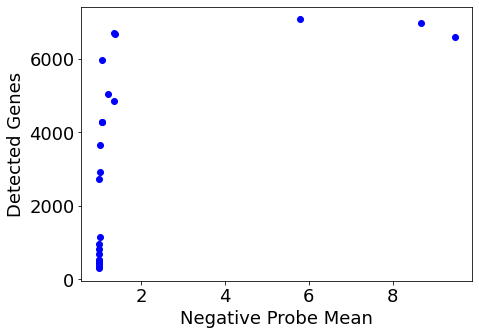

In [17]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)            # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(7,5))
plt.scatter(adata.obs['NegGeoMean_01'], adata.obs['DetectedGenes2.0'], c = 'blue')
plt.ylabel('Detected Genes')
plt.xlabel('Negative Probe Mean')
#plt.legend(ncol = 1, loc = 'upper center', handletextpad=0)
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_NegProbeMean_vs_DetectedGenes.pdf', bbox_tight = True)

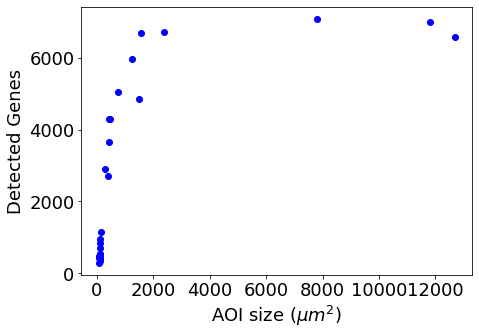

In [18]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)            # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(7,5))
plt.scatter(adata.obs['area um2'], adata.obs['DetectedGenes2.0'], c = 'blue')
plt.ylabel('Detected Genes')
plt.xlabel('AOI size (' + "$\mu m^2$" + ')')
#plt.legend(ncol = 1, loc = 'upper center', handletextpad=0)
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_Area_vs_DetectedGenes.pdf', bbox_tight = True)

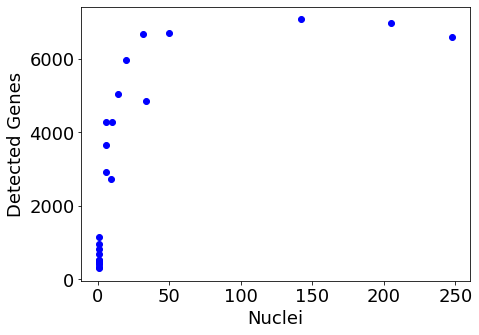

In [19]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)            # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(7,5))
plt.scatter(adata.obs['nuclei_counts'], adata.obs['DetectedGenes2.0'], c = 'blue')
plt.ylabel('Detected Genes')
plt.xlabel('Nuclei')
#plt.legend(ncol = 1, loc = 'upper center', handletextpad=0)
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_NucleiCounts_vs_DetectedGenes.pdf', bbox_tight = True)

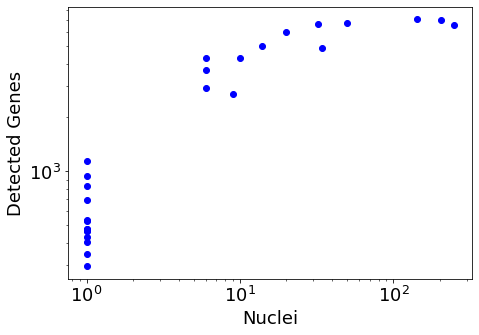

In [20]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)            # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(7,5))
plt.scatter(adata.obs['nuclei_counts'], adata.obs['DetectedGenes2.0'], c = 'blue')
plt.ylabel('Detected Genes')
plt.xlabel('Nuclei')
plt.xscale('log')
plt.yscale('log')
#plt.legend(ncol = 1, loc = 'upper center', handletextpad=0)
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_NucleiCounts_vs_DetectedGenes_logScaleBoth.pdf', bbox_tight = True)

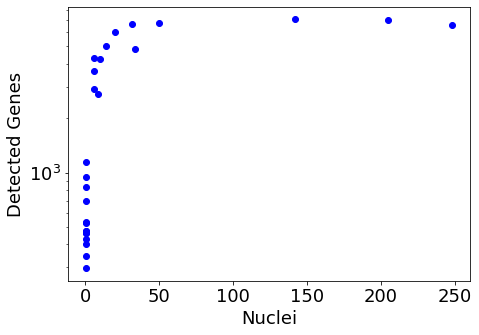

In [21]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)            # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(7,5))
plt.scatter(adata.obs['nuclei_counts'], adata.obs['DetectedGenes2.0'], c = 'blue')
plt.ylabel('Detected Genes')
plt.xlabel('Nuclei')
plt.yscale('log')
#plt.legend(ncol = 1, loc = 'upper center', handletextpad=0)
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_NucleiCounts_vs_DetectedGenes_logScaleY.pdf', bbox_tight = True)

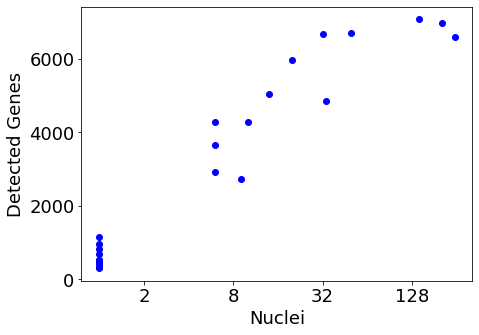

In [22]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)            # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.scatter(adata.obs['nuclei_counts'], adata.obs['DetectedGenes2.0'], c = 'blue')
ax.set_ylabel('Detected Genes')
ax.set_xlabel('Nuclei')
ax.set_xscale('log', basex = 2)
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: str(int(round(x)))))
#plt.legend(ncol = 1, loc = 'upper center', handletextpad=0)
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_NucleiCounts_vs_DetectedGenes_logScaleX.pdf', bbox_tight = True)

No handles with labels found to put in legend.


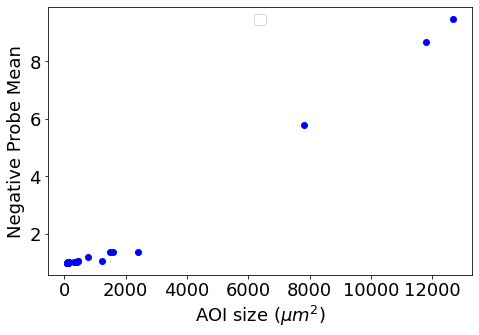

In [23]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)            # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(7,5))
plt.scatter(adata.obs['area um2'], adata.obs['NegGeoMean_01'], c = 'blue')
plt.ylabel('Negative Probe Mean')
plt.xlabel('AOI size (' + "$\mu m^2$" + ')')
plt.legend(ncol = 1, loc = 'upper center', handletextpad=0)
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_Area_vs_NegProbeMean.pdf', bbox_tight = True)

In [24]:
singecell_rois = (
4,
10,
12,
14,
15,
16,
17,
18,
19,
20,
21,
22,
23,
24,
25,
29,
30,
31,
32,
33
)
adata.obs['roi'] = [int(adata.obs['roi'].iloc[i]) for i in range(len(adata.obs['roi']))]
subset = [adata.obs['roi'].iloc[i] in singecell_rois for i in range(len(adata.obs['roi']))]
adata = adata[subset,]

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


No handles with labels found to put in legend.


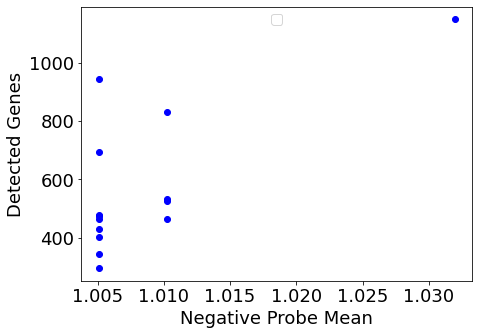

In [25]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)            # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(7,5))
plt.scatter(adata.obs['NegGeoMean_01'], adata.obs['DetectedGenes2.0'], c = 'blue')
plt.ylabel('Detected Genes')
plt.xlabel('Negative Probe Mean')
plt.legend(ncol = 1, loc = 'upper center', handletextpad=0)
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_NegProbeMean_vs_DetectedGenes.pdf', bbox_tight = True)

No handles with labels found to put in legend.


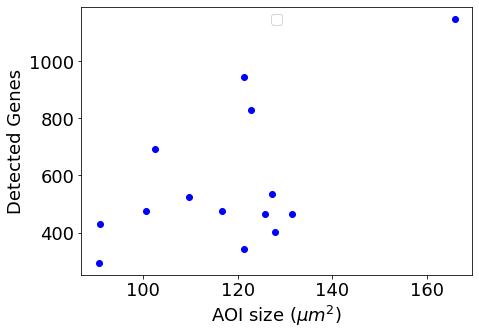

In [26]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)            # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(7,5))
plt.scatter(adata.obs['area um2'], adata.obs['DetectedGenes2.0'], c = 'blue')
plt.ylabel('Detected Genes')
plt.xlabel('AOI size (' + "$\mu m^2$" + ')')
plt.legend(ncol = 1, loc = 'upper center', handletextpad=0)
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_Area_vs_DetectedGenes.pdf', bbox_tight = True)

No handles with labels found to put in legend.


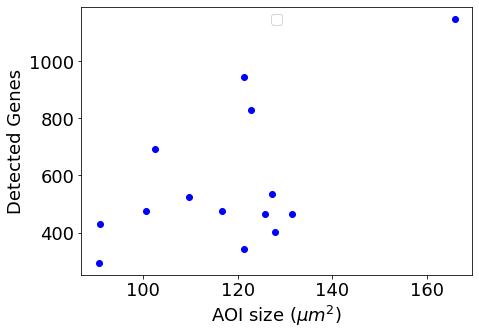

In [27]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)            # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

subset = adata.obs['NegGeoMean_01'] > 1

plt.figure(figsize=(7,5))
plt.scatter(adata.obs['area um2'].loc[subset], adata.obs['DetectedGenes2.0'].loc[subset], c = 'blue')
plt.ylabel('Detected Genes')
plt.xlabel('AOI size (' + "$\mu m^2$" + ')')
plt.legend(ncol = 1, loc = 'upper center', handletextpad=0)
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_Area_vs_DetectedGenes_Subset.pdf', bbox_tight = True)

In [28]:
markers = pd.read_csv('../data/fetalBrain/Polioudakis/clusterMarkers.csv')
oRG_markers = np.array(markers['gene'].loc[[markers['p_val'][i] < 0.01
                      and markers['cluster'][i] == 'oRG' for i in range(len(markers['cluster']))]])
oRG_index = [np.where(adata.var_names == g)[0][0] for g in oRG_markers if g in adata.var_names]

In [29]:
adata.obs['DetectedGenes2.0_oRG'] = np.sum(np.array([adata.X[i,oRG_index] >= adata.obs['GeoLOD2.0_01'].iloc[i] for i in range(len(adata.X[:,1]))]), axis = 1)

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


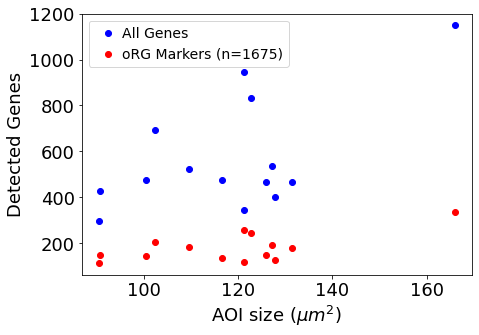

In [30]:
SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)            # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

subset = adata.obs['NegGeoMean_01'] > 1

plt.figure(figsize=(7,5))
plt.scatter(adata.obs['area um2'].loc[subset], adata.obs['DetectedGenes2.0'].loc[subset], c = 'blue', label = 'All Genes')
plt.scatter(adata.obs['area um2'].loc[subset], adata.obs['DetectedGenes2.0_oRG'].loc[subset], c = 'red',
            label = 'oRG Markers' + ' (n=' + str(len(oRG_markers)) + ')')
plt.ylabel('Detected Genes')
plt.xlabel('AOI size (' + "$\mu m^2$" + ')')
plt.legend(ncol = 1, loc = 'upper left', handletextpad=0)
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_Area_vs_DetectedGenes_Subset.pdf', bbox_tight = True)

Now map celltypes with cell2location

In [31]:
meanExpression_sc = pd.read_csv("data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)

In [32]:
wta_genes = np.asarray(adata.var_names)
common_genes = [wta_genes[i] for i in range(len(wta_genes)) if wta_genes[i] in meanExpression_sc.index] 
adata = adata[:,[adata.var_names[i] in common_genes + ['NegProbe-WTX'] for i in range(len(adata.var_names))]]
meanExpression_sc = meanExpression_sc.reindex(index = common_genes)

In [33]:
counts_geneProbes = np.asarray(adata[:,np.array(adata.var != 'NegProbe-WTX').squeeze()].X)
counts_negativeProbes = np.asarray(adata[:,np.array(adata.var =='NegProbe-WTX').squeeze()].X)
counts_nuclei = np.repeat(1, np.shape(counts_geneProbes)[0]).reshape(np.shape(counts_geneProbes)[0],1)

celltypes = meanExpression_sc.keys()
meanExpression_sc = np.asarray(meanExpression_sc)

In [34]:
model = isctools.ProbeCounts_CoLocationModel_NB_V1(
            cell_state_mat = meanExpression_sc,
            X_data = counts_geneProbes,
            Y_data = counts_negativeProbes,
            data_type='float32',
            n_iter=20000,
            learning_rate=0.001,
            fact_names=celltypes,
            gene_level_prior={'mean': 1/2, 'sd': 1/8, 'mean_var_ratio': 0.25},
            cell_number_prior={'cells_per_spot': counts_nuclei, 'factors_per_spot': 6, 'combs_per_spot': 50},
            cell_number_var_prior={'cells_mean_var_ratio': 0.01, 'factors_mean_var_ratio': 1, 'combs_mean_var_ratio': 1})

Average Loss = 2.2654e+05: 100%|██████████| 50000/50000 [02:14<00:00, 372.49it/s]
Finished [100%]: Average Loss = 2.2654e+05


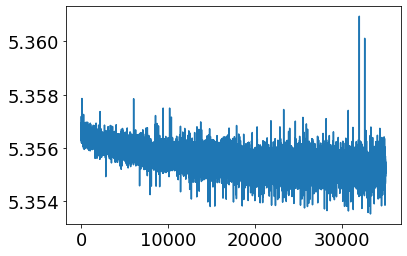

In [35]:
total_iterations = 50000
model.fit_advi_iterative(n_iter = total_iterations, learning_rate = 0.001, n=1, method='advi')

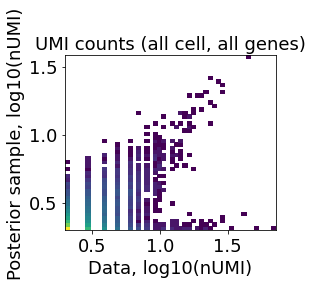

In [36]:
model.sample_posterior(node='all', n_samples=1000, save_samples=False);
model.compute_expected()
model.plot_posterior_mu_vs_data()
plt.show()

In [37]:
model.sample2df(node_name='spot_factors')

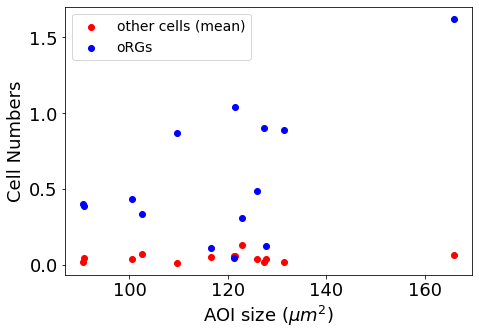

In [38]:
subset = np.array(adata.obs['NegGeoMean_01'] > 1)
plt.figure(figsize=(7,5))
plt.scatter(adata.obs['area um2'].loc[subset],
            np.mean(model.spot_factors_df.loc[:,model.spot_factors_df.columns != 'mean_spot_factorsoRG'].loc[subset],
                    axis = 1),
            label = 'other cells (mean)', c = 'red')
plt.scatter(adata.obs['area um2'].loc[subset], model.spot_factors_df['mean_spot_factorsoRG'].loc[subset], label = 'oRGs', c = 'blue')
plt.xlabel('AOI size (' + "$\mu m^2$" + ')')
plt.ylabel('Cell Numbers')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_Cell2location.pdf', bbox_tight = True)

Make a jitter plot of number of detected genes and how many of those are oRGs:

In [39]:
df = pd.DataFrame(data = np.array(adata.obs['DetectedGenes2.0'][subset]), columns = ['DetectedGenes'])

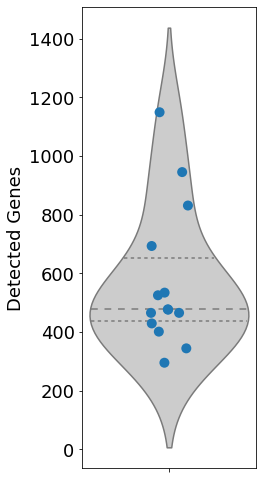

In [40]:
from numpy import mean

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)            # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(4,7))
ax = sns.violinplot(y ="DetectedGenes", data=df,
                    inner='quartiles', color=".8")
ax = sns.stripplot(y ="DetectedGenes", data=df, size = 10)
plt.ylabel('Detected Genes')
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_DetectedGenes_ViolinPlot.pdf', bbox_tight = True)

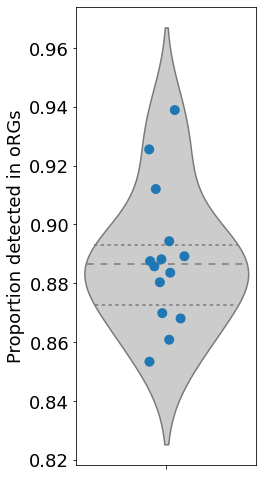

In [48]:
meanExpression_sc = pd.read_csv("data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)
oRG_genes = meanExpression_sc.index[meanExpression_sc['oRG'] > 0.02]
detected_genes = [list(adata.var_names[adata.X[i,:] >= adata.obs['GeoLOD2.0_01'].iloc[i]]) for i in range(len(adata.X[:,1]))]
overlap = [sum([detected_genes[i][j] in oRG_genes for j in range(len(detected_genes[i]))])/len(detected_genes[i]) for i in range(len(detected_genes))]
df = pd.DataFrame(data = np.array(overlap)[subset], columns = ['Overlap'])
from numpy import mean

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)            # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(4,7))
ax = sns.violinplot(y ="Overlap", data=df,
                    inner='quartiles', color=".8")
ax = sns.stripplot(y ="Overlap", data=df, size = 10)
plt.ylabel('Proportion detected in oRGs')
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_DetectedGenesOverlapORGs_ViolinPlot.pdf', bbox_tight = True)

Now do the same plot for IPs and INs:

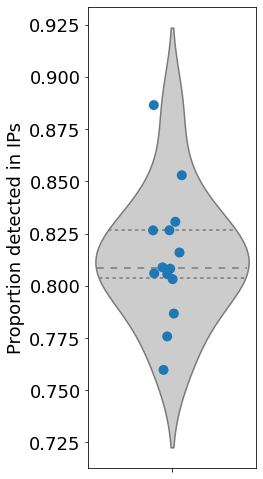

In [54]:
meanExpression_sc = pd.read_csv("data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)
IP_genes = meanExpression_sc.index[meanExpression_sc['IP'] > 0.02]
detected_genes = [list(adata.var_names[adata.X[i,:] >= adata.obs['GeoLOD2.0_01'].iloc[i]]) for i in range(len(adata.X[:,1]))]
overlap = [sum([detected_genes[i][j] in IP_genes for j in range(len(detected_genes[i]))])/len(detected_genes[i]) for i in range(len(detected_genes))]
df = pd.DataFrame(data = np.array(overlap)[subset], columns = ['Overlap'])
from numpy import mean

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)            # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(4,7))
ax = sns.violinplot(y ="Overlap", data=df,
                    inner='quartiles', color=".8")
ax = sns.stripplot(y ="Overlap", data=df, size = 10)
plt.ylabel('Proportion detected in IPs')
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_DetectedGenesOverlapIPs_ViolinPlot.pdf', bbox_tight = True)

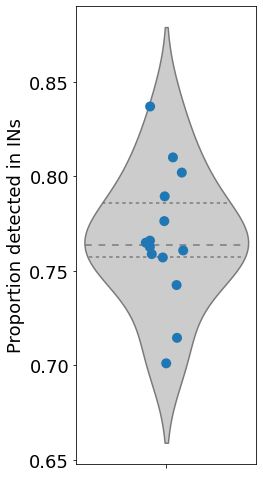

In [55]:
meanExpression_sc = pd.read_csv("data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)
IN_genes = meanExpression_sc.index[[meanExpression_sc['InMGE'].iloc[i] > 0.02 or meanExpression_sc['InCGE'].iloc[i] > 0.02 for i in range(len(meanExpression_sc['InMGE']))]]
detected_genes = [list(adata.var_names[adata.X[i,:] >= adata.obs['GeoLOD2.0_01'].iloc[i]]) for i in range(len(adata.X[:,1]))]
overlap = [sum([detected_genes[i][j] in IN_genes for j in range(len(detected_genes[i]))])/len(detected_genes[i]) for i in range(len(detected_genes))]
df = pd.DataFrame(data = np.array(overlap)[subset], columns = ['Overlap'])
from numpy import mean

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)            # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(4,7))
ax = sns.violinplot(y ="Overlap", data=df,
                    inner='quartiles', color=".8")
ax = sns.stripplot(y ="Overlap", data=df, size = 10)
plt.ylabel('Proportion detected in INs')
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_DetectedGenesOverlapINs_ViolinPlot.pdf', bbox_tight = True)

Also do all three plots for marker genes only:

In [91]:
cluster_markers = pd.read_csv("../data/fetalBrain/Polioudakis/clusterMarkers.csv", index_col=0)

In [92]:
meanExpression_sc = meanExpression_sc.loc[[g in cluster_markers['gene'] for g in meanExpression_sc.index],:]
cluster_markers = cluster_markers.loc[[g in meanExpression_sc.index for g in cluster_markers['gene']],:]

In [133]:
N = 10
cutoff = 0.02
oRG_markers = cluster_markers.loc[[cluster_markers['cluster'].iloc[i] == 'oRG' 
 and cluster_markers['p_val_adj'].iloc[i] == 0.0                  
 for i in range(len(cluster_markers['cluster']))],:] 
oRG_markers = np.array(oRG_markers.loc[[np.mean(meanExpression_sc.loc[:,('IP', 'InMGE', 'InCGE')], axis = 1)[oRG_markers['gene'].iloc[i]] < cutoff
                         for i in range(len(oRG_markers['gene']))],:]['gene'])

IP_markers = cluster_markers.loc[[cluster_markers['cluster'].iloc[i] == 'IP' 
 and cluster_markers['p_val_adj'].iloc[i] == 0.0                  
 for i in range(len(cluster_markers['cluster']))],:] 
IP_markers = np.array(IP_markers.loc[[meanExpression_sc.loc[:,'oRG'][IP_markers['gene'].iloc[i]] < cutoff
                         for i in range(len(IP_markers['gene']))],:]['gene'])

IN_markers = cluster_markers.loc[[cluster_markers['cluster'].iloc[i] in ('InMGE', 'InCGE') 
 and cluster_markers['p_val_adj'].iloc[i] == 0.0                  
 for i in range(len(cluster_markers['cluster']))],:] 
IN_markers = np.array(IN_markers.loc[[meanExpression_sc.loc[:,'oRG'][IN_markers['gene'].iloc[i]] < cutoff
                         for i in range(len(IN_markers['gene']))],:]['gene'])


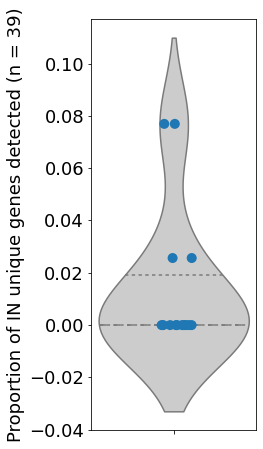

In [134]:
detected_genes = [list(adata.var_names[adata.X[i,:] >= adata.obs['GeoLOD2.0_01'].iloc[i]]) for i in range(len(adata.X[:,1]))]
overlap1 = [sum([IN_markers[j] in detected_genes[i] for j in range(len(IN_markers))])/len(IN_markers) for i in range(len(detected_genes))]
df = pd.DataFrame(data = np.array(overlap1)[subset], columns = ['Overlap'])
from numpy import mean

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)            # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(4,7))
ax = sns.violinplot(y ="Overlap", data=df,
                    inner='quartiles', color=".8")
ax = sns.stripplot(y ="Overlap", data=df, size = 10)
plt.ylabel('Proportion of IN unique genes detected (n = ' + str(len(IN_markers)) + ')')
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_DetectedGenesOverlapUniqueINsGenes_ViolinPlot.pdf', bbox_tight = True)

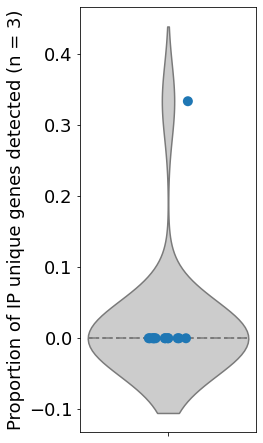

In [135]:
detected_genes = [list(adata.var_names[adata.X[i,:] >= adata.obs['GeoLOD2.0_01'].iloc[i]]) for i in range(len(adata.X[:,1]))]
overlap = [sum([IP_markers[j] in detected_genes[i] for j in range(len(IP_markers))])/len(IP_markers) for i in range(len(detected_genes))]
df = pd.DataFrame(data = np.array(overlap)[subset], columns = ['Overlap'])
from numpy import mean

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)            # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(4,7))
ax = sns.violinplot(y ="Overlap", data=df,
                    inner='quartiles', color=".8")
ax = sns.stripplot(y ="Overlap", data=df, size = 10)
plt.ylabel('Proportion of IP unique genes detected (n = ' + str(len(IP_markers)) + ')')
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_DetectedGenesOverlapUniqueIPsGenes_ViolinPlot.pdf', bbox_tight = True)

In [132]:
IP_markers

array([[0.0, 1.5673269466435098, 0.488, 0.043, 0.0, 'IP', 'EOMES'],
       [0.0, 1.2922334894002099, 0.364, 0.028999999999999998, 0.0, 'IP',
        'NHLH1'],
       [0.0, 0.7382538747210949, 0.163, 0.013999999999999999, 0.0, 'IP',
        'NEUROD4']], dtype=object)

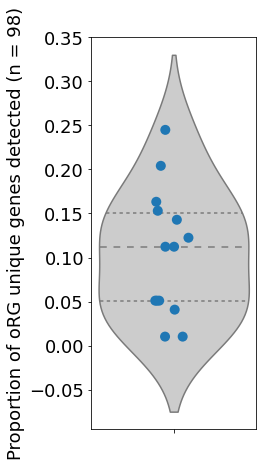

In [137]:
detected_genes = [list(adata.var_names[adata.X[i,:] >= adata.obs['GeoLOD2.0_01'].iloc[i]]) for i in range(len(adata.X[:,1]))]
overlap = [sum([oRG_markers[j] in detected_genes[i] for j in range(len(oRG_markers))])/len(oRG_markers) for i in range(len(detected_genes))]
df = pd.DataFrame(data = np.array(overlap)[subset], columns = ['Overlap'])
from numpy import mean

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)            # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(4,7))
ax = sns.violinplot(y ="Overlap", data=df,
                    inner='quartiles', color=".8")
ax = sns.stripplot(y ="Overlap", data=df, size = 10)
plt.ylabel('Proportion of oRG unique genes detected (n = ' + str(len(oRG_markers)) + ')')
plt.tight_layout()
plt.savefig('0_publication_figures/SingleNuclei_DetectedGenesOverlapUniqueORGsGenes_ViolinPlot.pdf', bbox_tight = True)